## Описание эксперимента

__Цель эксперимента__: обучение классификационной головы для предсказания четырех классов узлов щитовидной железы, используя в качестве feature extractor - сеть `EfficientNetB7` из общей архитектуры `Unet`, обученной на сегментацию узлов щитовидной железы.

In [2]:
# !pip install segmentation-models-pytorch==0.3.4

In [24]:
import os
import cv2
import numpy as np
import random
import torch
import seaborn as sns
import torch.nn as nn
from copy import copy
import torch.nn.functional as F
from tqdm.notebook import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import albumentations as A
from IPython.display import clear_output
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as transforms 
from sklearn.metrics import accuracy_score, f1_score
from scipy.special import softmax

import warnings
warnings.filterwarnings("ignore")

In [25]:
TEST_DIR_PATH = "/kaggle/input/rois-changed-areas/0.1_changed_roi_areas_10percent/test"
TRAIN_DIR_PATH = "/kaggle/input/rois-changed-areas/0.1_changed_roi_areas_10percent/train"

### Utils

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(pred_dict, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Визуализация матрицы ошибок из словаря предсказаний.
    
    Args:
        pred_dict (dict): Словарь {true_class: [predicted_classes]}
        classes (list): Список всех классов в правильном порядке
        normalize (bool): Нормализовать ли значения по строкам
        title (str): Заголовок графика
        cmap: Цветовая схема
    """
    # Инициализация матрицы
    n_classes = len(classes)
    conf_mat = np.zeros((n_classes, n_classes), dtype=np.int32)
    
    # Заполнение матрицы из словаря
    for true_class, pred_classes in pred_dict.items():
        true_idx = classes.index(true_class)
        for pred_class in pred_classes:
            pred_idx = classes.index(pred_class)
            conf_mat[true_idx][pred_idx] += 1
    
    # Нормализация (если нужно)
    if normalize:
        conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    # Визуализация
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    
    plt.title(title)
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [6]:
def get_folders(directory):
    folders = []
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            folders.append(item)
    return folders


def get_files(directory):
    files = []
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isfile(item_path):
            files.append(item)
    return files

In [7]:
def get_only_n_objects(x, n=4):
    new_x = []
    if len(x) >= n:
        step = len(x) // n
        for i in range(0, len(x), step):
            new_x.append(x[i])
            if len(new_x) == n:
                return new_x
    else:
        new_x = copy(x)
        while len(new_x) != n:
            new_x.append(
                random.choice(x)
            )
    return new_x

### Data Loading

In [8]:
def load_images_from_dir(path_dir: str):

    class_folders_names = get_folders(path_dir)
    class_folders_pathes = [os.path.join(path_dir, folder) for folder in class_folders_names]
    nodules_seqs_dirs = []
    for class_folder_path in class_folders_pathes:
        nodules_seqs = get_folders(class_folder_path)
        nodules_seqs_dirs.extend([os.path.join(class_folder_path, seq) for seq in nodules_seqs])
        
    images_pathes = [] 
    masks_pathes = []    

    for nodule_seq_dir in tqdm(nodules_seqs_dirs):
        label = int(nodule_seq_dir.split('_')[-2][-1])
        current_images_dir = os.path.join(nodule_seq_dir, 'images')
        current_masks_dir = os.path.join(nodule_seq_dir, 'masks')

        current_images_pathes = [os.path.join(current_images_dir, x) for x in get_files(current_images_dir)]
        current_masks_pathes = [os.path.join(current_masks_dir, x) for x in get_files(current_masks_dir)]
        
        current_images_pathes.sort(key=lambda x: int(x.split('/')[-1].split('.')[0]))
        current_masks_pathes.sort(key=lambda x: int(x.split('/')[-1].split('.')[0])) # Masks
        
        images_pathes.append(
            (current_images_pathes, label-2)
        )
        masks_pathes.append(
            (current_masks_pathes, label-2)
        )
        
    images = []
    for current_imgs_pathes, label in tqdm(images_pathes):
        current_images = []
        for image_path in current_imgs_pathes:
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                current_images.append(image)
        current_images = get_only_n_objects(current_images)
        images.append((current_images, label))

    return images

In [9]:
train_images = load_images_from_dir(TRAIN_DIR_PATH)
val_images = load_images_from_dir(TEST_DIR_PATH)

  0%|          | 0/323 [00:00<?, ?it/s]

  0%|          | 0/323 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

### Dataset and DataLoader initialization

In [12]:
train_images_splitted = []
val_images_splitted = []

for images_seq, label in train_images:
    train_images_splitted.extend(
        [(image, label) for image in images_seq]
    )
    
for images_seq, label in val_images:
    val_images_splitted.extend(
        [(image, label) for image in images_seq]
    )

In [13]:
len(train_images_splitted), len(val_images_splitted)

(1292, 448)

In [14]:
class CustomImageDataset(Dataset):
    def __init__(self, data_list, transform=None, is_imgaug=True):
        self.data_list = data_list
        self.transform = transform
        self.is_imgaug = is_imgaug
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        image, label = self.data_list[idx]
        
        if self.transform:
            if self.is_imgaug:
                transformed = self.transform(image=image)
                image = transformed["image"]
                return image, torch.tensor(label, dtype=torch.long)
            else:
                transformed = self.transform(np.repeat(image[:, :, 0][:, :, np.newaxis], 3, -1))
                return transformed[0, :, :].unsqueeze(0), torch.tensor(label, dtype=torch.long)


def get_val_transforms():
    return A.Compose([
        A.Resize(height=256, width=256),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

def get_train_transforms():
    return A.Compose([
        # Геометрические преобразования (отражения, повороты)
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.Transpose(p=0.3),  # Транспонирование (поворот на 90° + отражение)
        
        # Искажения перспективы и формы
        A.Perspective(scale=(0.05, 0.1), p=0.3),  # Случайная перспектива
        A.ElasticTransform(alpha=1, sigma=20, alpha_affine=10, p=0.3),  # Эластичные деформации
        
        # Цветовые преобразования
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.RandomGamma(gamma_limit=(80, 120), p=0.3),  # Гамма-коррекция
        
        # Размытия и шумы
        A.GaussianBlur(blur_limit=(3, 5), p=0.2),  # Размытие по Гауссу
        A.GaussNoise(var_limit=(5.0, 20.0), p=0.2),  # Гауссов шум
        
        # Обрезка и масштабирование
        A.Resize(height=512, width=512),  # Фиксированный размер
        
        # Нормализация и преобразование в тензор
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

train_dataset = CustomImageDataset(
    train_images_splitted,
    transform=get_train_transforms(),
)

test_dataset = CustomImageDataset(
    val_images_splitted,
    transform=get_val_transforms(),
)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=32)

In [15]:
for x, y in train_loader:
    break

### Model initialization

In [16]:
unet_plus_plus = torch.load("/kaggle/input/unet_effnetb7_pretrained/other/default/1/Unet-timm-efficientnet-b7_dice-0.950.pt", weights_only=False)
encoder = unet_plus_plus.encoder

In [ ]:
class ClsHead(nn.Module):
    def __init__(
        self,
        n_classes=4,
    ):
        super().__init__()
        self._encoder = encoder
        self._cls_head = nn.Sequential(
            nn.Linear(640, 2),
            nn.Mish(),
            nn.Linear(2, 16),
            nn.Mish(),
            nn.Linear(16, 2),
            nn.Mish(),
            nn.Linear(2, n_classes)
        )
        
    def forward(self, x):
        with torch.no_grad():
            x = self._encoder(x)[-1]
        x = x.mean(dim=(-2, -1))
        x = self._cls_head(x)
        return x

### Training utils

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import numpy as np

device = 'cuda'

num_classes = 4

def calculate_class_metrics(targets, preds, num_classes=num_classes):
    """Вычисляет метрики для каждого класса отдельно"""
    class_metrics = {
        'accuracy': [],
        'f1': [],
        'precision': [],
        'recall': []
    }

    targets = np.array(targets)
    preds = np.array(preds)
    
    for class_id in range(num_classes):
        # Бинаризируем для текущего класса
        bin_targets = (targets == class_id).astype(int)
        bin_preds = (preds == class_id).astype(int)
        
        # Вычисляем метрики
        class_metrics['accuracy'].append(accuracy_score(bin_targets, bin_preds))
        class_metrics['f1'].append(f1_score(bin_targets, bin_preds, zero_division=0))
        class_metrics['precision'].append(precision_score(bin_targets, bin_preds, zero_division=0))
        class_metrics['recall'].append(recall_score(bin_targets, bin_preds, zero_division=0))
    
    return class_metrics

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(train_loader.dataset)

    # Calculate class metrics
    class_metrics = calculate_class_metrics(all_targets, all_preds, num_classes)
    
    # Calculate general metrics
    epoch_f1 = f1_score(all_targets, all_preds, average='macro')
    epoch_precision = precision_score(all_targets, all_preds, average='macro')
    epoch_recall = recall_score(all_targets, all_preds, average='macro')
    epoch_accuracy = accuracy_score(all_targets, all_preds)
    
    return epoch_loss, epoch_accuracy, epoch_f1, epoch_precision, epoch_recall, class_metrics

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(val_loader.dataset)

    # Calculate class metrics
    class_metrics = calculate_class_metrics(all_targets, all_preds, num_classes)
    
    # Calculate general metrics
    epoch_f1 = f1_score(all_targets, all_preds, average='macro')
    epoch_precision = precision_score(all_targets, all_preds, average='macro')
    epoch_recall = recall_score(all_targets, all_preds, average='macro')
    epoch_accuracy = accuracy_score(all_targets, all_preds)
    
    return epoch_loss, epoch_accuracy, epoch_f1, epoch_precision, epoch_recall, class_metrics

def train_model(model, train_loader, val_loader, num_epochs, device='cuda', num_classes=4, balance=True):

    from sklearn.utils.class_weight import compute_class_weight
    labels = []
    for _, l in val_loader.dataset:
        labels.append(l.item())

    # cnt = Counter(labels)
    # weights = np.array([1, cnt[0] / cnt[1]])
    
    if balance:
        weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    else:
        weights = np.array([1] * num_classes)

    
    
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float32).to(device))
    optimizer = optim.AdamW(model.parameters())
    
    best_val_f1 = 0.0
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'train_f1': [],
        'train_precision': [],
        'train_recall': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_f1': [],
        'val_precision': [],
        'val_recall': [],
        'train_class_metrics': [],
        'val_class_metrics': []
    }
    
    for epoch in range(num_epochs):
        # Training
        train_loss, train_acc, train_f1, train_prec, train_rec, train_class_metrics = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        
        # Validation
        val_loss, val_acc, val_f1, val_prec, val_rec, val_class_metrics = validate_epoch(
            model, val_loader, criterion, device
        )
        
        # Save metrics to history
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['train_f1'].append(train_f1)
        history['train_precision'].append(train_prec)
        history['train_recall'].append(train_rec)
        history['train_class_metrics'].append(train_class_metrics)
        
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_precision'].append(val_prec)
        history['val_recall'].append(val_rec)
        history['val_class_metrics'].append(val_class_metrics)
        
        # Clear previous output and plot new graphs
        clear_output(wait=True)
        plt.figure(figsize=(20, 15))
        
        # Plot Loss
        plt.subplot(3, 4, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.title('Loss')
        plt.legend()
        
        # Plot Accuracy
        plt.subplot(3, 4, 2)
        plt.plot(history['train_accuracy'], label='Train Accuracy')
        plt.plot(history['val_accuracy'], label='Val Accuracy')
        plt.title('Accuracy')
        plt.legend()
        
        # Plot F1 Score
        plt.subplot(3, 4, 3)
        plt.plot(history['train_f1'], label='Train F1')
        plt.plot(history['val_f1'], label='Val F1')
        plt.title('Macro F1 Score')
        plt.legend()
        
        # Plot Precision
        plt.subplot(3, 4, 4)
        plt.plot(history['train_precision'], label='Train Precision')
        plt.plot(history['val_precision'], label='Val Precision')
        plt.title('Macro Precision')
        plt.legend()
        
        # Plot Class-wise F1 Scores
        for class_id in range(num_classes):
            plt.subplot(3, 4, 5 + class_id)
            train_class_f1 = [x['f1'][class_id] for x in history['train_class_metrics']]
            val_class_f1 = [x['f1'][class_id] for x in history['val_class_metrics']]
            plt.plot(train_class_f1, label=f'Train F1 (Class {class_id})')
            plt.plot(val_class_f1, label=f'Val F1 (Class {class_id})')
            plt.title(f'Class {class_id} F1 Score')
            plt.legend()
        
        # Plot Class-wise Accuracy
        for class_id in range(num_classes):
            plt.subplot(3, 4, 9 + class_id)
            train_class_acc = [x['accuracy'][class_id] for x in history['train_class_metrics']]
            val_class_acc = [x['accuracy'][class_id] for x in history['val_class_metrics']]
            plt.plot(train_class_acc, label=f'Train Acc (Class {class_id})')
            plt.plot(val_class_acc, label=f'Val Acc (Class {class_id})')
            plt.title(f'Class {class_id} Accuracy')
            plt.legend()
        
        # Print metrics for current epoch
        plt.tight_layout()
        plt.show()
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
        print(f'Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}')
        print(f'Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}')
        
        for class_id in range(num_classes):
            print(f'Class {class_id} - Val F1: {val_class_metrics["f1"][class_id]:.4f}, '
                  f'Val Acc: {val_class_metrics["accuracy"][class_id]:.4f}')
        
        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pth')
            print("Saved new best model!")
    
    print(f'Training complete. Best validation F1: {best_val_f1:.4f}')
    return history

### Model Training

In [22]:
model = ClsHead()
model = model.to('cuda')

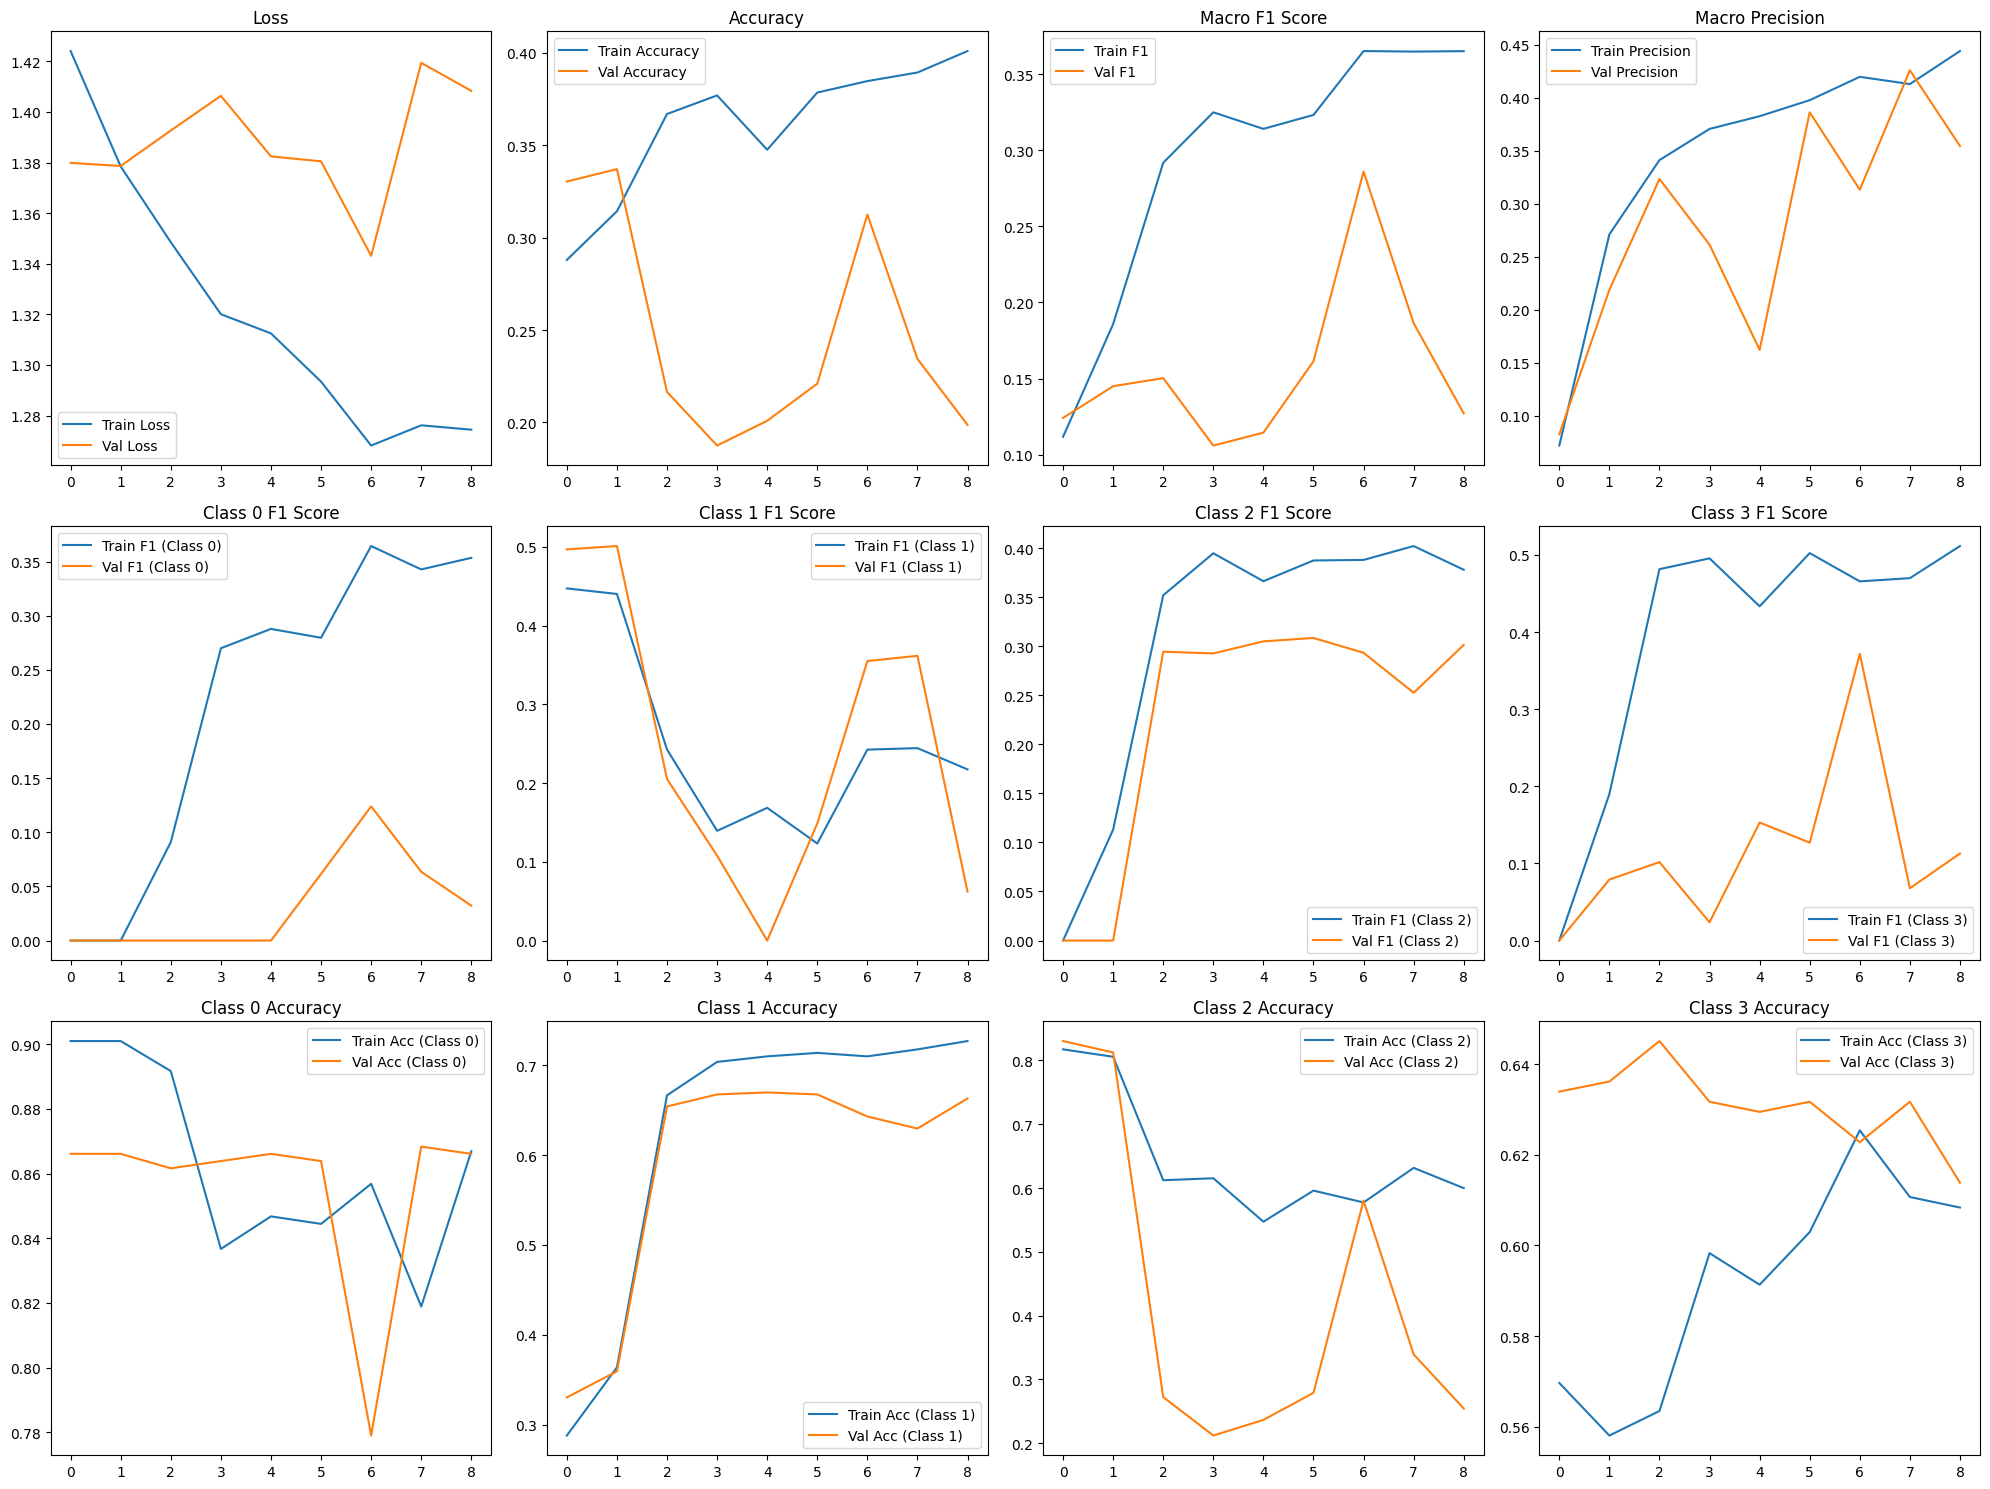

Epoch 9/50
Train Loss: 1.2744 | Val Loss: 1.4083
Train Acc: 0.4009 | Val Acc: 0.1987
Train F1: 0.3650 | Val F1: 0.1271
Class 0 - Val F1: 0.0323, Val Acc: 0.8661
Class 1 - Val F1: 0.0621, Val Acc: 0.6629
Class 2 - Val F1: 0.3013, Val Acc: 0.2545
Class 3 - Val F1: 0.1128, Val Acc: 0.6138


  0%|          | 0/41 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [23]:
train_model(model, train_loader, test_loader, num_epochs=50)

<module 'numpy' from '/usr/local/lib/python3.11/dist-packages/numpy/__init__.py'>

### Model Scoring

In [80]:
predictions = defaultdict(list)

In [81]:
model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))
model.eval()
for i in tqdm(range(len(test_dataset))):
    features, label = test_dataset[i]
    out = model(features.to('cuda').unsqueeze(0))
    
    true_label = label.item()
    
    predictions[true_label].append(out.argmax(dim=1).item())

  0%|          | 0/448 [00:00<?, ?it/s]

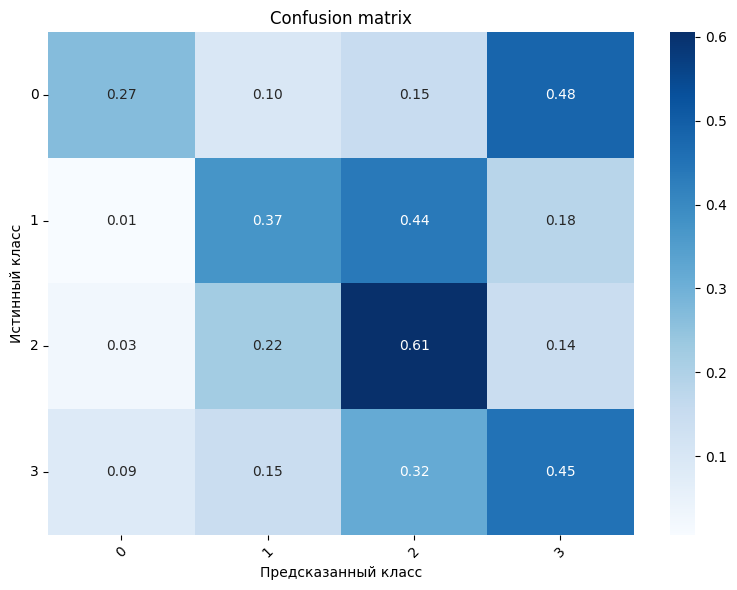

In [82]:
plot_confusion_matrix(predictions, [0, 1, 2, 3])

In [29]:
model = ClsHead().to('cuda')
model._cls_head.load_state_dict(torch.load("/kaggle/input/unet_cls_head/other/default/1/best_model (9).pth"))

<All keys matched successfully>

In [30]:
train_predictions = []
val_predictions = []

for i in tqdm(range(len(train_dataset))):
    features, label = train_dataset[i]
    out = model(features.to('cuda').unsqueeze(0))
    out = out[0].detach().cpu().numpy().tolist()
    train_predictions.append(out)
    
for i in tqdm(range(len(test_dataset))):
    features, label = test_dataset[i]
    out = model(features.to('cuda').unsqueeze(0))
    out = out[0].detach().cpu().numpy().tolist()
    val_predictions.append(out)

  0%|          | 0/1292 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

In [37]:
pd.DataFrame(train_predictions, columns=["p1", "p2", "p3", "p4"]).to_csv("train_predictions_unet.csv", index=False)

In [38]:
pd.DataFrame(val_predictions, columns=["p1", "p2", "p3", "p4"]).to_csv("val_predictions_unet.csv", index=False)